In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
options = 'results=8000&timezone=America%2FSao_Paulo'
data = requests.get('https://api.thingspeak.com/channels/657211/feeds.json?'+options).content
feeds = json.loads(data)['feeds']

In [3]:
feeds[0]

{'created_at': '2019-09-22T22:50:08-03:00',
 'entry_id': 115968,
 'field1': None,
 'field2': None,
 'field3': '29.20',
 'field4': '59.00\r\n\r\n',
 'field5': None,
 'field6': None}

In [4]:
feeds[-1]

{'created_at': '2019-09-28T10:18:38-03:00',
 'entry_id': 123967,
 'field1': None,
 'field2': None,
 'field3': None,
 'field4': None,
 'field5': '23.00',
 'field6': '56.00\r\n\r\n'}

In [5]:
def clean_date(string):
    return datetime.strptime(string[:-6], '%Y-%m-%dT%H:%M:%S')

In [6]:
df = pd.DataFrame.from_dict(feeds)
fields = [x for x in df.columns if x.startswith('field')]
for field in fields:
    df[field] = df[field].str.replace('\r\n','').astype(float)
df['created_at'] = pd.to_datetime(df['created_at'].apply(clean_date))

In [7]:
raw_old = pd.read_pickle('raw_data.pickle')
df = raw_old.append(df).drop_duplicates()
df.to_pickle('raw_data.pickle')
df.tail()

,created_at,entry_id,field1,field2,field3,field4,field5,field6
7995,2019-09-28 10:10:30,123963,NaN,NaN,NaN,NaN,23.0,57.0
7996,2019-09-28 10:12:33,123964,NaN,NaN,NaN,NaN,23.0,56.0
7997,2019-09-28 10:14:35,123965,NaN,NaN,NaN,NaN,23.0,56.0
7998,2019-09-28 10:16:36,123966,NaN,NaN,NaN,NaN,23.0,57.0
7999,2019-09-28 10:18:38,123967,NaN,NaN,NaN,NaN,23.0,56.0


In [8]:
df2 =  df.set_index('created_at').resample("5T").mean()[fields]

In [9]:
df_old = pd.read_pickle('data.pickle')
#df_old = pd.DataFrame([])
df_old = df_old.append(df2)
df_old = df_old.drop_duplicates().resample("5T").mean()[fields]

In [10]:
df_old.tail()

,field1,field2,field3,field4,field5,field6
created_at,,,,,,
2019-09-28 09:55:00,NaN,NaN,NaN,NaN,23.0,57.500000
2019-09-28 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-28 10:05:00,NaN,NaN,NaN,NaN,23.0,55.000000
2019-09-28 10:10:00,NaN,NaN,NaN,NaN,23.0,56.333333
2019-09-28 10:15:00,NaN,NaN,NaN,NaN,23.0,56.500000


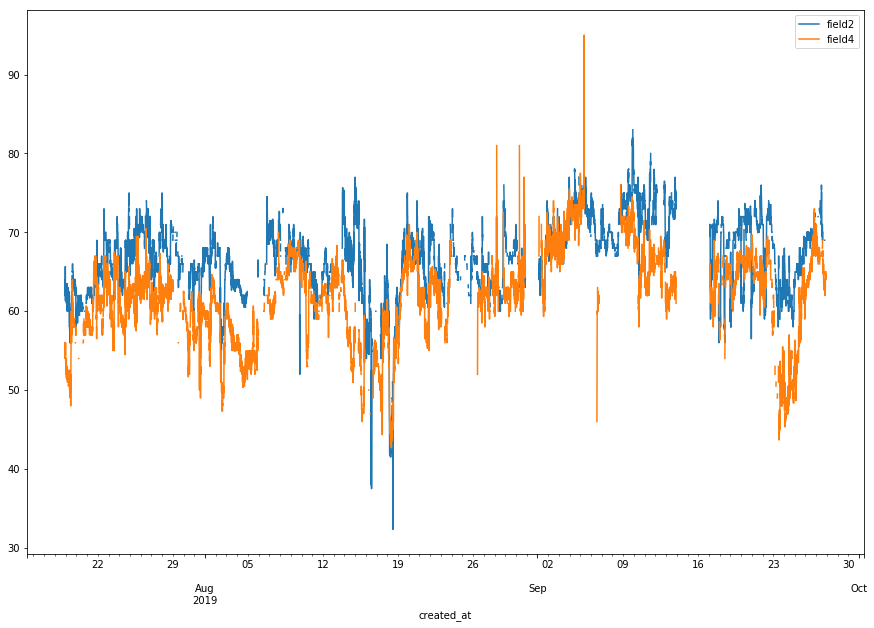

In [11]:
df_old[['field2','field4']].plot(figsize=(15,10),)

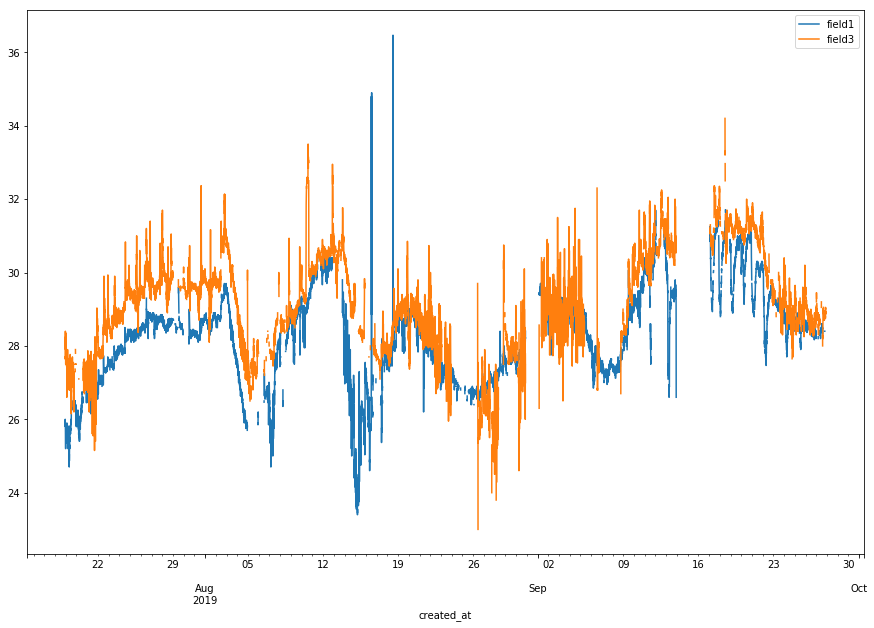

In [12]:
df_old[['field1','field3']].plot(figsize=(15,10))

In [13]:
df_old.to_pickle('data.pickle')

In [14]:
dfx = df_old.reset_index()
dfx.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
dfx['date2'] = dfx['created_at'].dt.hour + dfx['created_at'].dt.minute/60 + dfx['created_at'].dt.second/3600
dfx.tail()

,created_at,field1,field2,field3,field4,field5,field6,date2
20587,2019-09-28 09:55:00,28.4,72.0,28.9,64.666667,23.0,57.500000,9.916667
20588,2019-09-28 10:00:00,28.4,72.0,28.9,64.666667,23.0,56.250000,10.000000
20589,2019-09-28 10:05:00,28.4,72.0,28.9,64.666667,23.0,55.000000,10.083333
20590,2019-09-28 10:10:00,28.4,72.0,28.9,64.666667,23.0,56.333333,10.166667
20591,2019-09-28 10:15:00,28.4,72.0,28.9,64.666667,23.0,56.500000,10.250000


In [15]:
limits = [(int(dfx[['field1','field3']].min().min()),int(dfx[['field1','field3']].max().max()+1)),
          (int(dfx[['field2','field4']].min().min()),int(dfx[['field2','field4']].max().max())+1)]
limits

[(23, 37), (32, 96)]

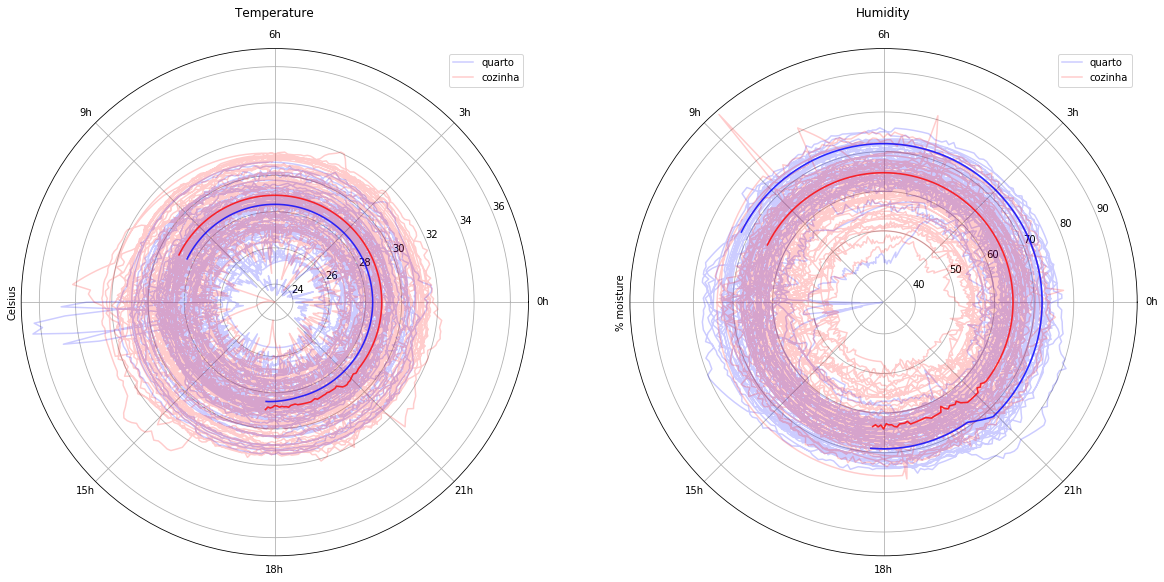

In [16]:
dfx['theta'] = dfx['date2']  * np.pi / 24. * 2
last = 200

fig = plt.figure(figsize=(20,30))

## Temperature
ax = fig.add_subplot(1,2,1,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Temperature')
plt.ylabel('Celsius')
ax.plot(dfx['theta'] , dfx['field1'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field3'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field1'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field3'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(limits[0])
ax.legend(('quarto','cozinha'))

## Humidity
ax = fig.add_subplot(1,2,2,projection='polar')
ax.set_xticklabels(['0h', '3h', '6h', '9h', '', '15h', '18h', '21h'])
plt.title('Humidity')
plt.ylabel('% moisture')
ax.plot(dfx['theta'] , dfx['field2'], alpha=.2 ,color='blue' )
ax.plot(dfx['theta'] , dfx['field4'], alpha=.2,color='red' )
ax.plot(dfx['theta'][-last:] , dfx['field2'][-last:], alpha=.8,lw=1.6 ,color='blue')
ax.plot(dfx['theta'][-last:] , dfx['field4'][-last:], alpha=.8,lw=1.6 ,color='red' )
plt.ylim(limits[1])
ax.legend(('quarto','cozinha'))

plt.savefig('plot.png',dpi=96, bbox_inches = 'tight')
plt.show()



In [17]:
dfx.describe()

,field1,field2,field3,field4,field5,field6,date2,theta
count,20592.000000,20592.000000,20592.000000,20592.000000,9708.000000,9708.000000,20592.000000,20592.000000
mean,28.276409,67.005445,29.118048,61.831207,22.767323,61.975062,11.928030,3.122751
std,1.345964,4.634873,1.390526,5.689854,1.705695,8.930929,6.936950,1.816089
min,23.400000,32.333333,23.000000,42.666667,19.000000,29.000000,0.000000,0.000000
25%,27.360000,64.000000,28.100000,58.887255,21.000000,58.000000,5.916667,1.548980
50%,28.400000,67.000000,29.050000,62.333333,23.000000,62.409632,11.916667,3.119776
75%,29.050000,70.333333,30.100000,65.500000,24.000000,67.000000,17.916667,4.690572
max,36.466667,83.000000,34.200000,95.000000,31.000000,87.000000,23.916667,6.261369


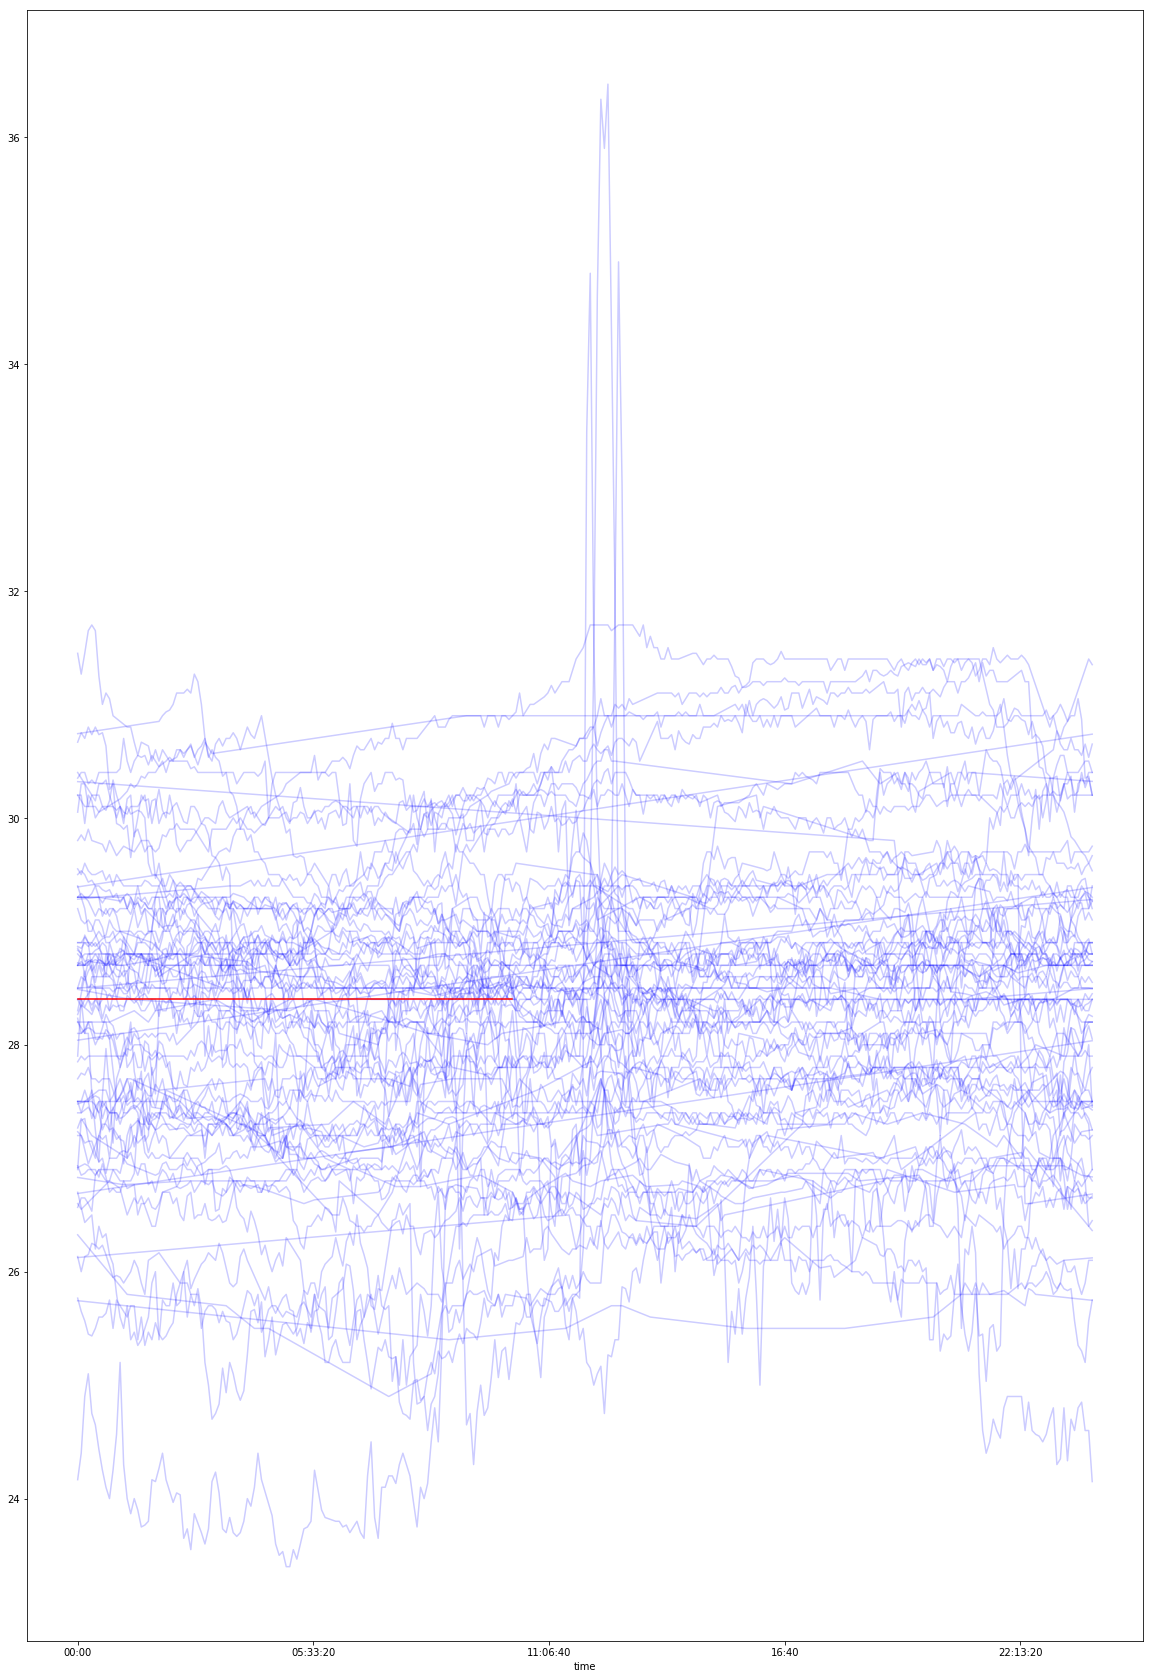

In [18]:
d2 = dfx[['created_at','field1']].groupby(dfx['created_at'].dt.date)
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(1,1,1)

for d in d2:
    if str(d[0]) == str(datetime.now().strftime("%Y-%m-%d")):
        ax.plot(d[1]['created_at'].dt.time , d[1]['field1'], alpha=1 ,color='red' )
    else:
        ax.plot(d[1]['created_at'].dt.time , d[1]['field1'], alpha=.2 ,color='blue' )

plt.savefig('plot_field1.png',dpi=96, bbox_inches = 'tight')
plt.show()

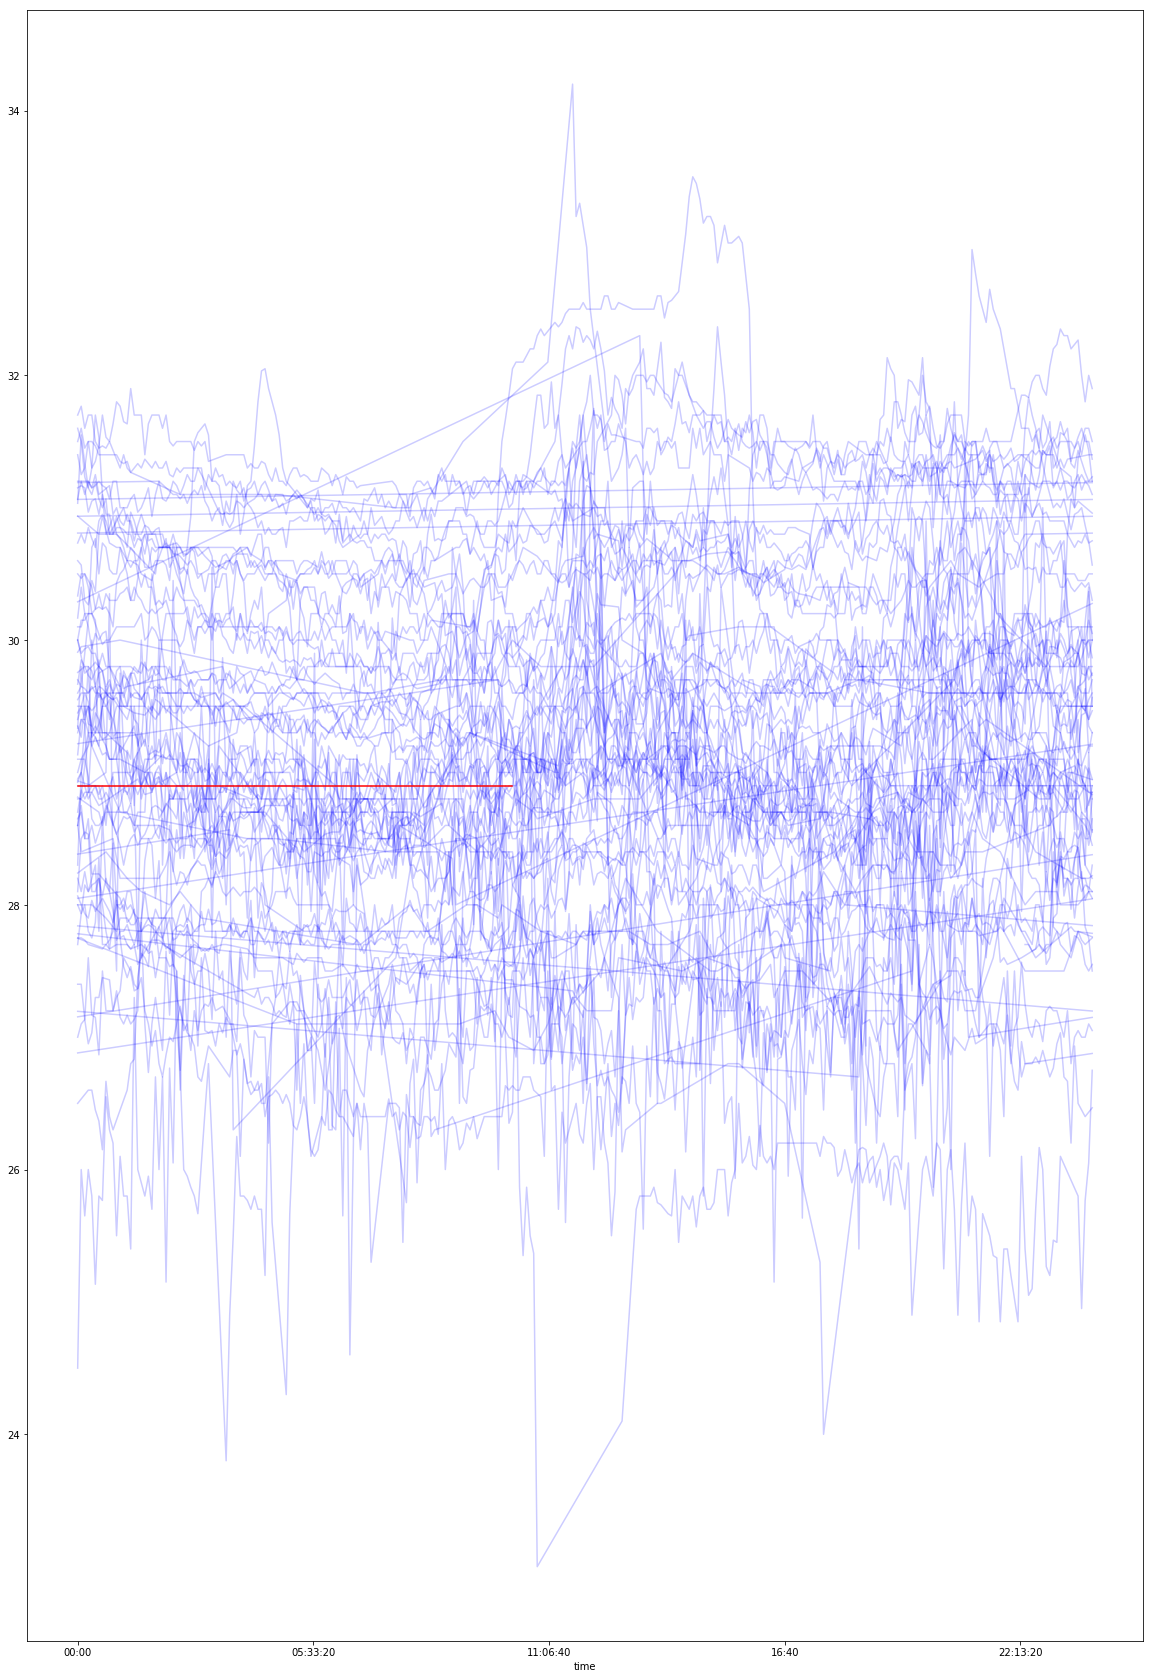

In [19]:
d2 = dfx[['created_at','field3']].groupby(dfx['created_at'].dt.date)
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(1,1,1)

for d in d2:
    if str(d[0]) == str(datetime.now().strftime("%Y-%m-%d")):
        ax.plot(d[1]['created_at'].dt.time , d[1]['field3'], alpha=1 ,color='red' )
    else:
        ax.plot(d[1]['created_at'].dt.time , d[1]['field3'], alpha=.2 ,color='blue' )
plt.savefig('plot_field3.png',dpi=96, bbox_inches = 'tight')
plt.show()